In [1]:
import numpy as np
from scipy.integrate import odeint
from scipy.linalg import inv
import matplotlib.pyplot as plt
np.random.seed(14)

# Single specie without magnetic noise simulation

In this simulation we assume there is no magnetic noise and no effective magnetic field of the alkali spin. Then, the phase of the Xenon with respect to the drive is given by

\begin{align}
    \phi_{129} &= -\frac{\gamma^{129}_{Xe}B_0}{\Gamma_2^{129}}-\frac{\omega_r}{\Gamma_2^{129}}+\frac{\omega^{129}_{rf}}{\Gamma_2^{129}}
\end{align}


In [2]:
# symbols
pi_c = chr(960)
phi_c = chr(966)
omega_c = chr(969)
big_omega_c = chr(937)


# physical units and constants
g129 = -74.4069*1e6       # rad  s^-1 T^-1 http://www.acadiau.ca/~bellis/resources/nmr/isotopes.html
g131 = 22.0564*1e6        # rad  s^-1 T^-1 http://www.acadiau.ca/~bellis/resources/nmr/isotopes.html
G2T = 1e-4
T2G = 1e4


In [3]:
class Xenon:
  def __init__(self, gamma, t1, t2, K0=np.array([0.05, 0.03, 0.95]), name='129'):
    
    self.name = name
    # Physical parameters
    self.gamma = gamma      # The xenon gyromagnetic ration   [rad  s^-1 T^-1] 
    
    # Decays
    self.t1 = t1            # T1 of xenon                     [s]
    self.t2 = t2            # T2 of xenon                     [s]
    self.gamma1 = 1. / t1   #                                 [s^-1]
    self.gamma2 = 1. / t2   #                                 [s^-1]
    
    # System parameters
    self.w0 = 0          # Larmor frequency                [rad  s^-1]
    self.wd_x = 0        # x drive frequency               [rad  s^-1]
    self.Ad_x = 0        # x drive amplitude               [s^-1]
    self.wd_y = 0        # y drive frequency               [rad  s^-1]
    self.Ad_y = 0        # y drive amplitude               [s^-1]
    
    # Spin polarization
    self.K = K0
    self.Kt = np.zeros((3, ))
    self.Ksteady = None
    self.Rse = np.array([0, 0, 0])

    # Bloch matrix
    self.M = np.zeros((3, 3))

    # boolean params
    self.drive = True

  def set_z_bias_field(self, B0):
    """Set z bias field"""
    self.w0 = self.gamma * B0

  def set_x_drive_field(self, drive_amplitude, drive_frequency):
    """Set NMR x drive"""
    assert (self.wd_y == 0 and self.Ad_y == 0)
    self.Ad_x = drive_amplitude
    self.wd_x = drive_frequency

  def set_y_drive_field(self, drive_amplitude, drive_frequency):
    """Set NMR y drive"""
    assert (self.wd_x == 0 and self.Ad_x == 0)
    self.Ad_y = drive_amplitude
    self.wd_y = drive_frequency

  def set_spin_exchange_amp(self, rse):
    """Set spin exchange pumping"""
    self.Rse = rse

  def set_bloch_matrix(self, B0, wr):
    """Constructing the Bloch matrix of the dynamics"""
    M = np.array(
        [
          [-self.gamma2 , 0              , 0             ],
          [0            , -self.gamma2   , 0             ],
          [0            , 0              , -self.gamma1  ] 
          ]
    )
    M12 = self.gamma * B0 + wr
    if self.drive:
      M[0, 2] = -self.Ad_y / 2.
      M[1, 2] = self.Ad_x / 2.
      M[2, 0] = self.Ad_y / 2.
      M[2, 1] = -self.Ad_x / 2.
      M12 = M12  - self.wd_x - self.wd_y

    M[0, 1] = M12
    M[1, 0] = -M12
    self.M = M

  def bloch_equations(self, K, t):
    """Bloch dynamics model"""
    dK_dt = np.matmul(self.M, K) + self.Rse
    return dK_dt
  
  def solve_dynamics(self, ts):
    Kt = self.K
    Kt = odeint(self.bloch_equations, Kt, ts)
    self.Kt = Kt[-1, :]
    return Kt

  def solve_steady_state(self):
    self.Ksteady = -inv(self.M) @ self.Rse
  
  def display_params(self):
    print('===================================================================')
    print(f'| Xenon {self.name}:')
    print(f'| ----------')
    print(f'| gyromagnetic ratio:     {self.gamma}')
    print(f'| T1:                     {self.t1}')
    print(f'| T2:                     {self.t2}')
    print(f'| {omega_c}d_x:                   {self.wd_x}')
    print(f'| {big_omega_c}d_x:                   {self.Ad_x}')
    print(f'| {omega_c}d_y:                   {self.wd_y}')
    print(f'| {big_omega_c}d_y:                   {self.Ad_y}')
    print(f'| use drive:              {self.drive}')
    print(f'| K0:                     {self.K}')
    print(f'| Kt:                     {self.Kt}')
    print(f'| K steady:               {self.Ksteady}')
    print('===================================================================')



In [ ]:
class MagneticSetup:
  def __init__(self):
    self.B0 = 0
    self.Ad_x = 0
    self.wd_x = 0
    self.Ad_y = 0
    self.wd_y = 0

In [4]:

t1 = 30       # s
t2 = 8        # s
B0 = 1 * G2T  # Tesla
wr = 0.01     # rad / s     
Ad = 2 * np.sqrt((1 / t1) * (1 / t2))  # 1 / s
wd = g129 * 1 * G2T                    # rad / s
Rse = np.array([0, 0, 0.1]) * t1       # |K| / s


Xe129 = Xenon(gamma=g129, t1=t1, t2=t2, name='129')
#Xe129.drive = False
Xe129.K = np.array([-0.0259, 0.00, 0.05])
Xe129.set_z_bias_field(B0)
Xe129.set_y_drive_field(Ad, wd)
Xe129.set_bloch_matrix(B0, wr)
Xe129.set_spin_exchange_amp(Rse)
Xe129.solve_steady_state()

# solve ODE
ts = np.linspace(0, 200, 3000)
Kt = Xe129.solve_dynamics(ts)

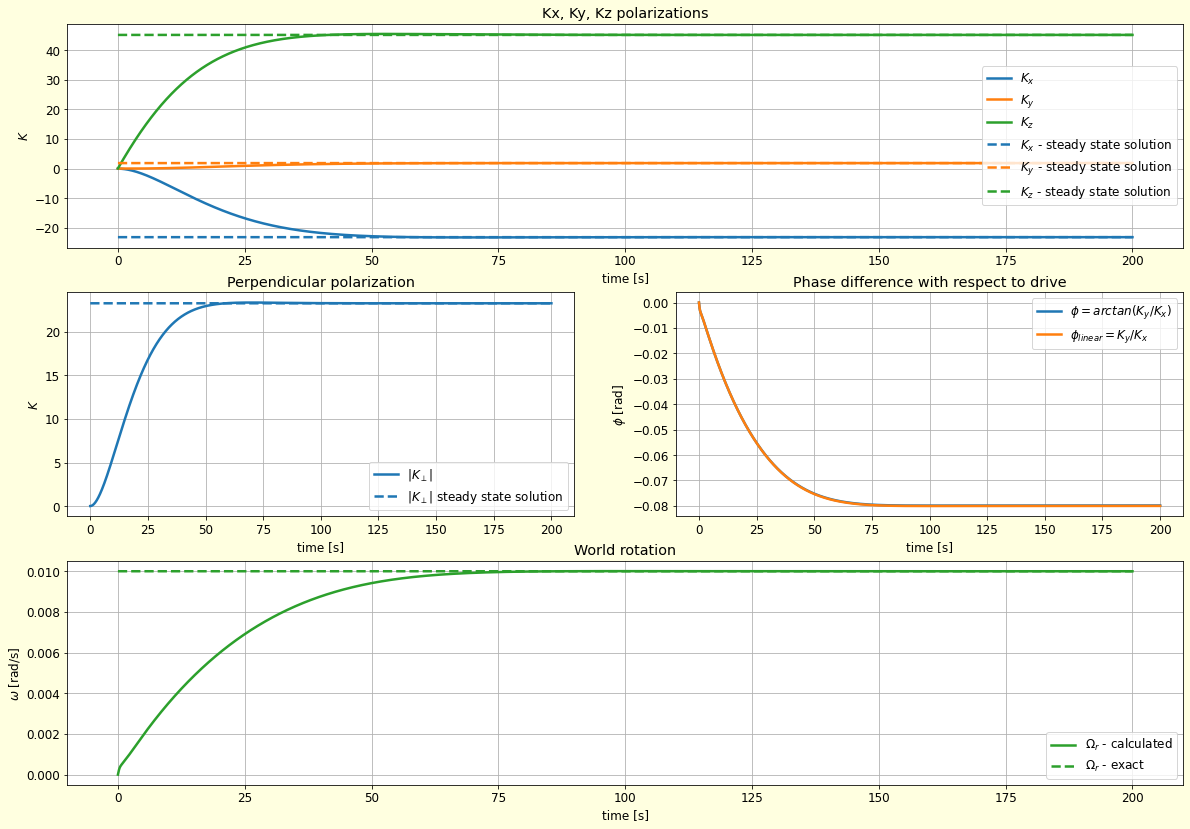

In [5]:
# Plot the spin solution
plt.rcParams.update({'font.size': 12})  # increase the font size
plt.rcParams['axes.facecolor'] = 'white'
plt.rcParams["figure.facecolor"] = 'lightyellow'
plt.rcParams["figure.facecolor"] = 'lightyellow'
plt.rcParams["lines.linewidth"] = 2.5

fig = plt.figure(figsize=(20, 14))

ax1 = plt.subplot(3, 2, (1, 2))
ax1.set_title('Kx, Ky, Kz polarizations' )
ax1.set_xlabel("time [s]")
ax1.set_ylabel("$K$")
ax1.plot(ts, Kt[:, 0], label='$K_x$', color='tab:blue')
ax1.plot(ts, Kt[:, 1], label='$K_y$', color='tab:orange')
ax1.plot(ts, Kt[:, 2], label='$K_z$', color='tab:green')
ax1.plot(ts, Xe129.Ksteady[0] * np.ones_like(ts), '--', label='$K_x$ - steady state solution', color='tab:blue')
ax1.plot(ts, Xe129.Ksteady[1] * np.ones_like(ts), '--', label='$K_y$ - steady state solution', color='tab:orange')
ax1.plot(ts, Xe129.Ksteady[2] * np.ones_like(ts), '--',  label='$K_z$ - steady state solution', color='tab:green')
ax1.legend()
ax1.grid(True)


K_perp = np.sqrt(Kt[:, 0] ** 2 + Kt[:, 1] ** 2)
K_perp_steady = np.sqrt(Xe129.Ksteady[0] ** 2 + Xe129.Ksteady[1] ** 2) * np.ones_like(ts)
ax2 = plt.subplot(3, 2, 3)
ax2.plot(ts, K_perp, label='$|K_{\perp}|$', color='tab:blue')
ax2.plot(ts, K_perp_steady, '--', label='$|K_{\perp}|$ steady state solution', color='tab:blue')
ax2.set_xlabel("time [s]")
ax2.set_ylabel("$K$")
ax2.grid(True)
ax2.legend()
ax2.set_title('Perpendicular polarization')

phi = np.arctan(Kt[:, 1] / Kt[:, 0])
phi_linear = Kt[:, 1] / Kt[:, 0]
ax3 = plt.subplot(3, 2, 4)
ax3.plot(ts, phi, label='$\phi = arctan(K_y/K_x)$')
ax3.plot(ts, phi_linear, label='$\phi_{linear} = K_y/K_x$')
ax3.set_xlabel("time [s]")
ax3.set_ylabel("$\phi$ [rad]")
ax3.grid(True)
ax3.legend()
ax3.set_title('Phase difference with respect to drive')

world_rotation = -phi_linear * Xe129.gamma2 + Xe129.gamma * B0 - Xe129.wd_y
ax4 = plt.subplot(3, 2, (5, 6))
ax4.plot(ts, world_rotation, label='$\Omega_r$ - calculated', color='tab:green')
ax4.plot(ts, wr * np.ones_like(ts), '--', label='$\Omega_r$ - exact', color='tab:green')
ax4.set_xlabel("time [s]")
ax4.set_ylabel("$\omega$ [rad/s]")
ax4.grid(True)
ax4.legend()
ax4.set_title('World rotation')

plt.tight_layout
plt.show()